In [ ]:
%pip install matplotlib
%pip install geopandas

In [ ]:
# Manipulacion de datos
import pandas as pd
import numpy as np
from google.colab import drive

# Graficadores
import seaborn as sns  # Por ahora no lo usamos. Quizas lo borramos.
from matplotlib import pyplot as plt
import geopandas as gp
from matplotlib.patches import Patch

# Calculos
import scipy.linalg as la  # Por ahora no lo usamos. Quizas lo borramos.
import random

# Modelos
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Coeficiente de Silhouette
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [ ]:
propiedades = pd.read_csv('/content/dataframe_punto1.csv')
coordenadas_bsas = gp.read_file(r'./barrios.geojson.json')

# Agrupamiento

En este apartado, estudiamos si las propiedades obtenidas del preprocesamiento realizado tienen una tendencia al agrupamiento con algun criterio, utilizando el algoritmo de **K-Means**.

## Tendencia al Clustering

Para empezar nuestro trabajo, analizamos la tendencia al clustering que posee nuestro dataframe, por medio de la estadística de Hopkins.

In [ ]:
def Hopkins(df, *args, seed = 0):
    n = df.shape[0]
    d = df.shape[1]
    if not args:
        print("Numero de puntos al azar por defecto")
        m = int(0.1 * n)
    else:
        m = args[0]

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df)
    rand_ind = list(range(0, n, 1))
    rand_ind = rand_ind[seed:(m + seed)]

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True)
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True)
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

Despues de repetir el analisis con multiples variables (no los agregamos para no hacer demasiado extenso y costoso de correr), decidimos realizar el agrupamiento con las variables *ambientes* y *superficie_total*, ya que consideramos que son las más abarcativas y representativas de todas (tanto *dormitorios* como *superficie_cubierta* estan incluidas dentro de las dos variables, y consideramos al *precio* como un resultado de las anteriores cuatro).

In [ ]:
propiedades_atributos = propiedades[propiedades.columns.difference(['id',
                                                                    'nombre',
                                                                    'fecha_inicio',
                                                                    'fecha_fin',
                                                                    'precio',
                                                                    'barrio',
                                                                    'tipo',
                                                                    'latitud',
                                                                    'longitud',
                                                                    'dormitorios',
                                                                    'superficie_cubierta'])]

escalado = MinMaxScaler()
propiedades_atributos_escalados = escalado.fit_transform(propiedades_atributos)
hopkins_ = Hopkins(propiedades_atributos_escalados)
round(hopkins_, 5)

Numero de puntos al azar por defecto


0.00035

El valor de hopkins obtenido (0.00034) indica que las observaciones del dataframe con las variables seleccionadas, tienen una poca tendencia a agruparse ya que están distribuidos de manera muy uniforme o aleatoria.

Esto nos lleva a sospechar que las variables elegidas fueron correctas, ya que aportan informacion importante.

## Estimacion de la Cantidad de Clusters

A pesar del resultado obtenido de la estadistica de Hopkins, buscamos la cantidad de clusters que se forman en nuestro dataset con las variables elegidas.

### Metodo del Codo

Empezamos con el método del codo estimando la cantidad adecuada de grupos para entrenar nuestro modelo **K-Means**.

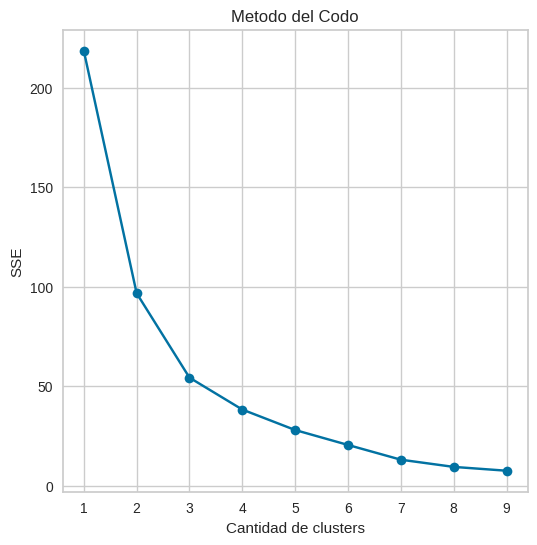

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters = k, n_init = 10)
    km.fit(propiedades_atributos_escalados)
    sse.append(km.inertia_)

plt.figure(figsize = (6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.title('Metodo del Codo')
plt.show()

Segun este metodo, estimamos que la cantidad apropiada es de clusters 3, ya que partir de este valor la inercia se reduce de manera  mas gradual.

### Coeficiente de Silhouette

Para confirmar nuestra estimacion obtenida del metodo del codo, calculamos y graficamos el coeficiente de Silhouette para cada valor de k (cantidad de clusters, con k de 2 hasta 9), con el objetivo de analizar cuál es la opción más adecuada para entrenar nuestro modelo.

Vale aclarar que el análisis por medio del coeficiente de Silhouette es más preciso que el metodo del codo, por lo que estos resultados tendran mayor peso a la hora de tomar una decisión.

In [ ]:
coefs_silhouette = []
list_k = list(range(2, 10))

for k in list_k:
    clusterer = KMeans(n_clusters = k, n_init = 10)
    preds = clusterer.fit_predict(propiedades_atributos_escalados)

    score = silhouette_score(propiedades_atributos_escalados, preds)
    coefs_silhouette.append(score)
    print("Para k =", k ,", el coeficiente de silhouette es:", score)

Para k = 2 , el coeficiente de silhouette es: 0.6144717514915142
Para k = 3 , el coeficiente de silhouette es: 0.6582392073264389
Para k = 4 , el coeficiente de silhouette es: 0.6942160956451406
Para k = 5 , el coeficiente de silhouette es: 0.8271630248216466
Para k = 6 , el coeficiente de silhouette es: 0.8291369627723643
Para k = 7 , el coeficiente de silhouette es: 0.8651194323960418
Para k = 8 , el coeficiente de silhouette es: 0.8658019797844206
Para k = 9 , el coeficiente de silhouette es: 0.8751094508835678


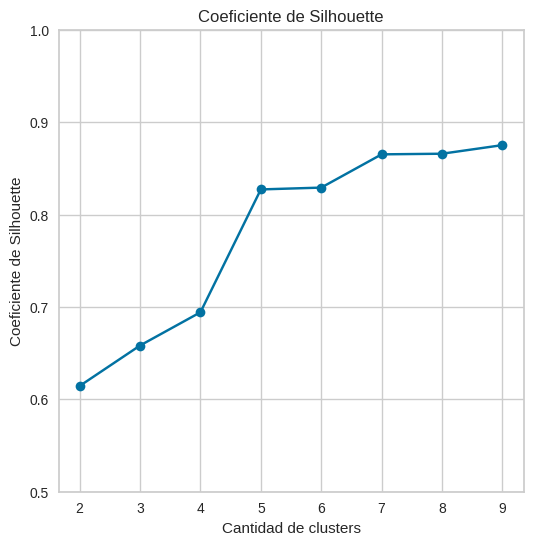

In [ ]:
plt.figure(figsize = (6, 6))
plt.plot(list_k, coefs_silhouette, '-o')
plt.xlabel('Cantidad de clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette')
plt.yticks([i/10 for i in range(5, 11)])
plt.show()

Observamos que los umbrales mas altos obtenidos pertenecen a ${k=7}$, ${k=8}$ y ${k=9}$, lo que indica que si todos los clusters formados en sus respectivos graficos superan este umbral, dichos clusters tendran una gran tendencia a la agrupacion. En un segundo escalon aunque no tan lejos, estan los umbrales que pertenecen a ${k=5}$ y ${k=6}$, que a pesar de no estar en el mismo nivel que los primeros tres, se puede obtener la misma conclusion de ellos si sus clusters superan el umbral. Por ultimo estan ${k=2}$, ${k=3}$ y ${k=4}$, que ni siquiera superan el umbral del 0,7. Cabe destacar que, mientras más cercano sea el valor del coeficiente de Silhouette a 1, mejor clasificación tienen los clusters y por lo tanto los puntos están más cerca de sus vecinos.

En base a las conclusiones obtenidas del grafico, realizamos un gráfico de Silhouette para ${k=5}$, ${k=6}$, ${k=7}$, ${k=8}$ y ${k=9}$, ya que son valores cosiderablementes cercanos a 1.

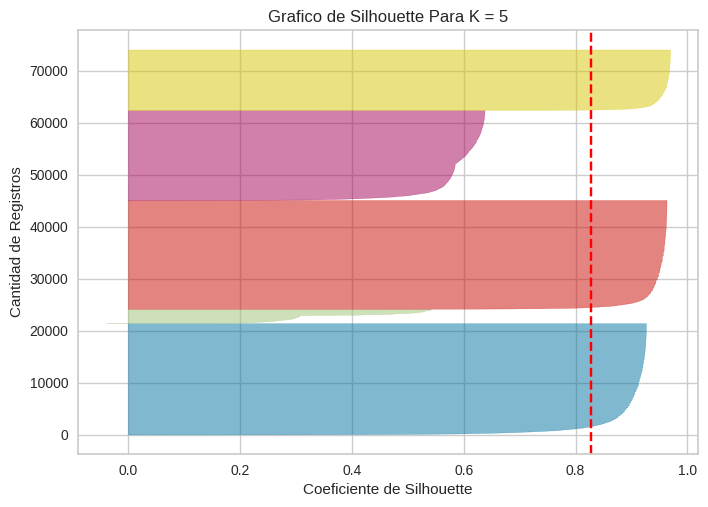

In [ ]:
modelo = KMeans(5, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 5')
plt.show()

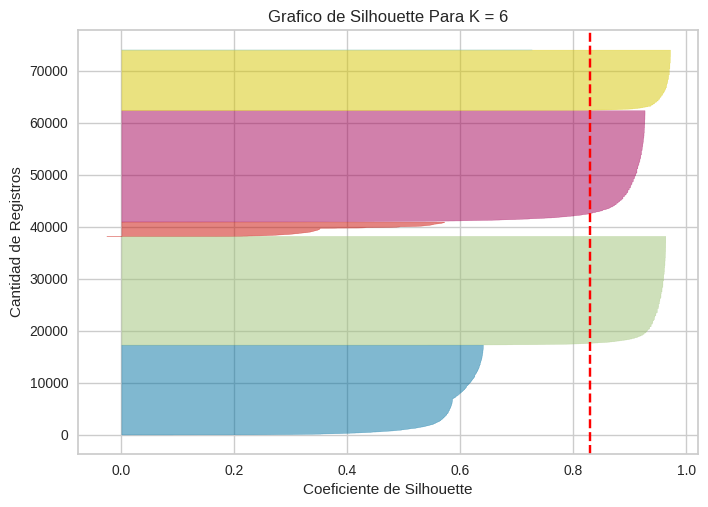

In [ ]:
modelo = KMeans(6, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 6')

plt.show()

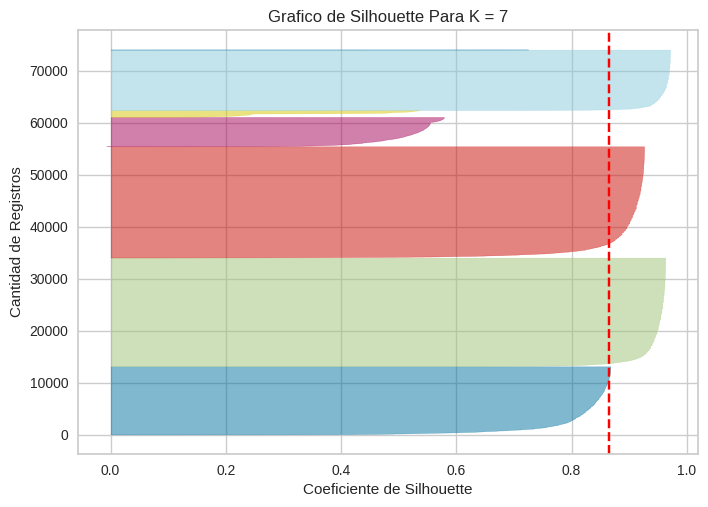

In [ ]:
modelo = KMeans(7, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 7')

plt.show()

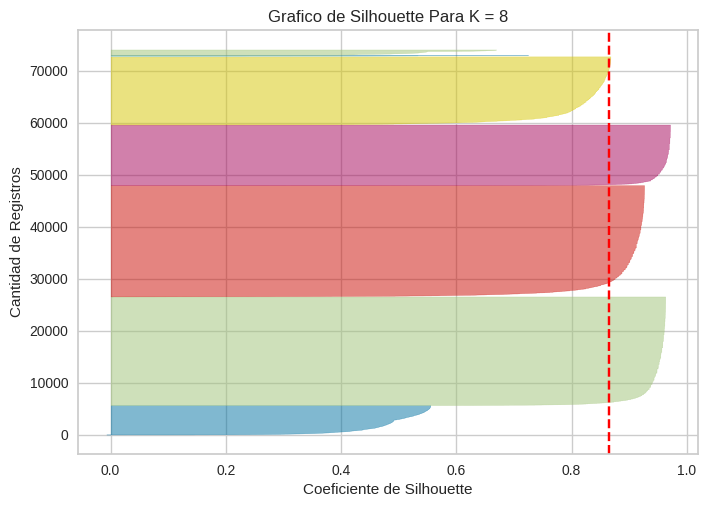

In [ ]:
modelo = KMeans(8, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 8')

plt.show()

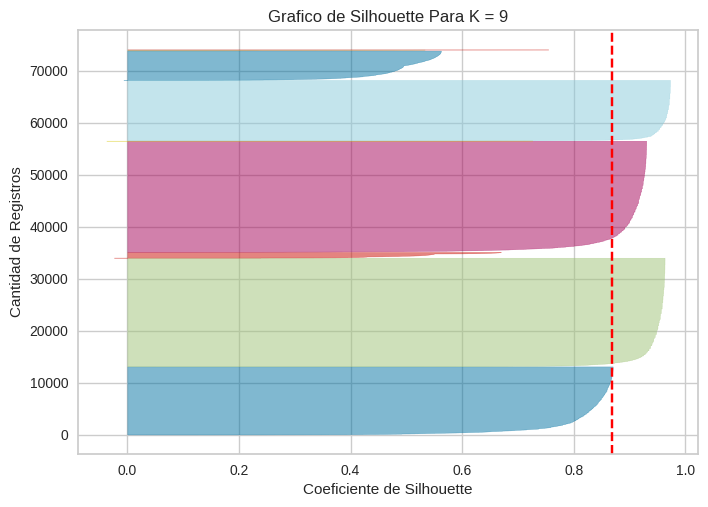

In [ ]:
modelo = KMeans(9, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 9')

plt.show()

Como se puede observar en los graficos, no obtuvimos buenos resultados en ningun grafico, ya que gran cantidad de grupos poseen todas sus instancias por debajo del umbral del coeficiente de Silhouette.

Por lo tanto, analizamos los graficos de Silhouette para ${k=2}$, ${k=3}$ y ${k=4}$.

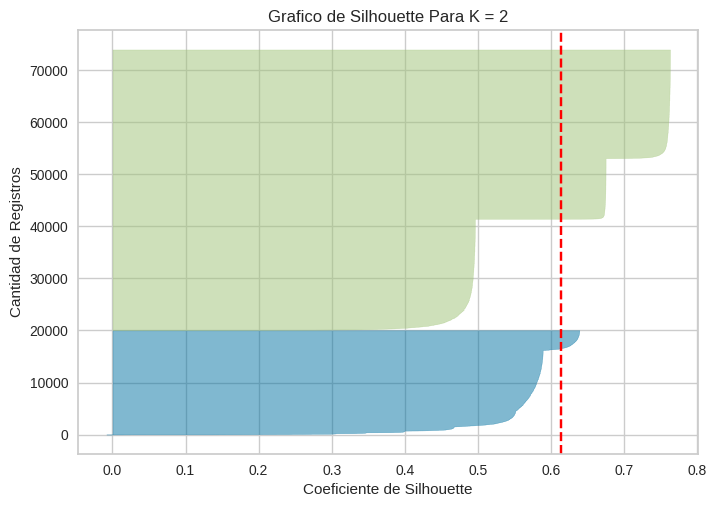

In [ ]:
modelo = KMeans(2, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors='yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 2')

plt.show()

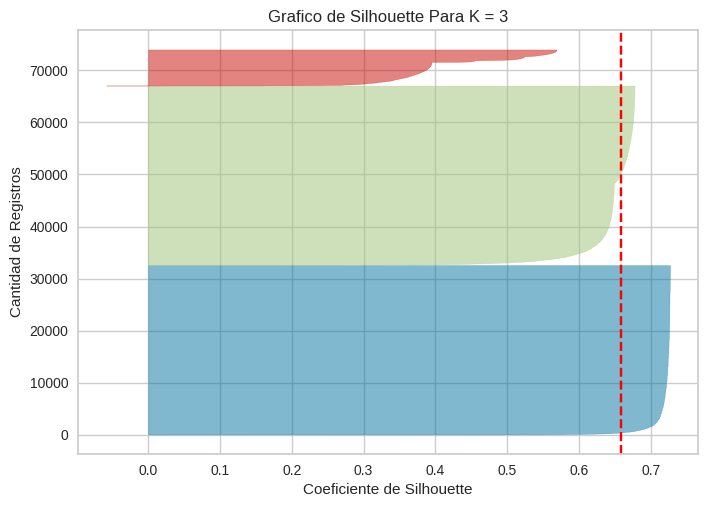

In [ ]:
modelo = KMeans(3, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 3')

plt.show()

Aquí observamos que para ${k=3}$ la totalidad de observaciones del grupo <font color='red'>rojo</font> no logran alcanzar el umbral de Silhouette. Más aún, vemos que hay observaciones que poseen un coeficiente de Silhouette negativo, lo que implica que dichas observaciones fueron mal asignadas a su grupo actual.

Por lo tanto, concluimos que esta cantidad de grupos no es tan optima para entrenar a nuestro modelo, contradiciendo la estimación del metodo del codo.


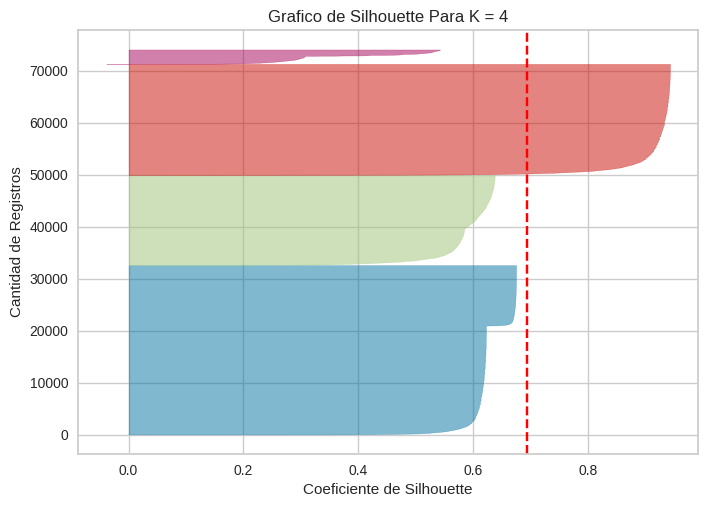

In [ ]:
modelo = KMeans(4, n_init = 10, random_state = 0)

visualizer = SilhouetteVisualizer(modelo, colors = 'yellowbrick')
visualizer.fit(propiedades_atributos_escalados)

plt.xlabel('Coeficiente de Silhouette')
plt.ylabel('Cantidad de Registros')
plt.title('Grafico de Silhouette Para K = 4')

plt.show()

Luego de analizar los greficos de Silhouette de todos los k, concluimos que la cantidad de clusters más óptima es ${k=2}$, ya que ambos clusters superan el umbral calculado en el coeficiente de Silhouette.

Cabe destacar que a pesar de esto, hay un gran grupo de registros dentro de ambos cluesters que no superan el umbral, lo que nos indica que no estan tan bien agrupados. Dicho esto, el grafico de Silhouette de ${k=2}$ es el unico en el que todos sus clusters superan el umbral, y por esta razon lo elegimos.

## Entrenamiento del Modelo K-Means

Por lo anterior, entrenamos al modelo **K-Means** eligiendo como hiperparametro 2 clusters (${k=2}$).

In [ ]:
kmeans_2 = KMeans(n_clusters = 2, n_init = 10, random_state = 0)

y_kmeans_2 = kmeans_2.fit_predict(propiedades_atributos_escalados)

Y graficamos el resultado.

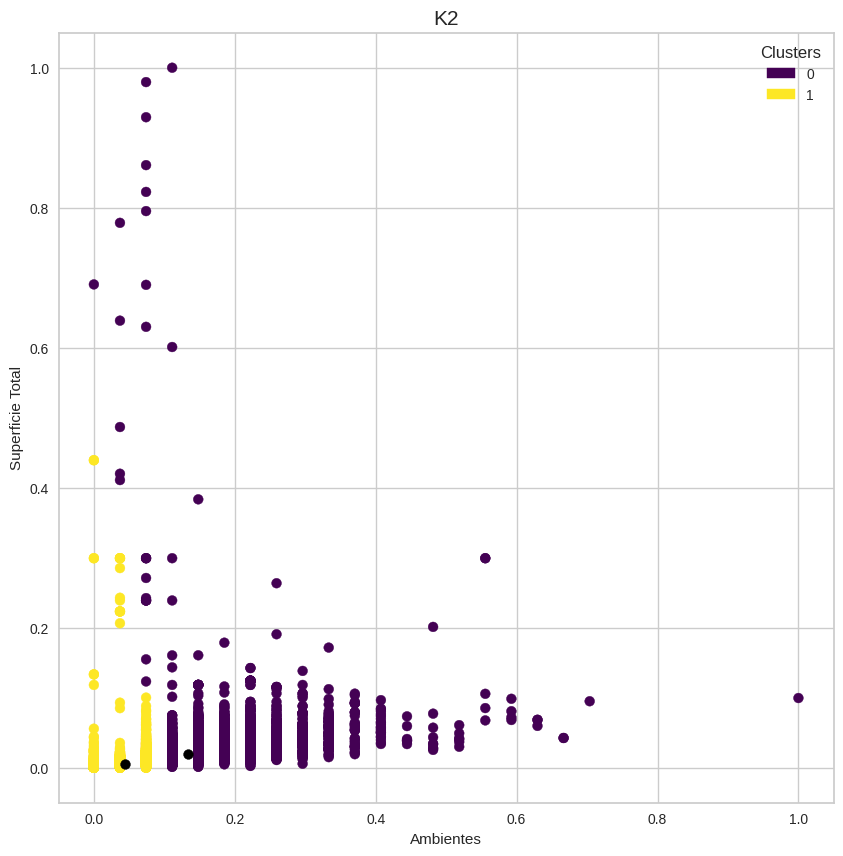

In [ ]:
grupos_kmeans_2 = pd.DataFrame(y_kmeans_2)
grupos_kmeans_2.rename(columns = {0:'grupo'}, inplace=True)

color_map = {0: '#440154FF', 1: '#FDE725FF'}
colores = grupos_kmeans_2['grupo'].map(color_map)

fx, ax = plt.subplots(figsize=(10,10))

plt.scatter(propiedades_atributos_escalados[:, 0], propiedades_atributos_escalados[:, 1], s = 50, c = colores)

legend_elements = [Patch(facecolor = '#440154FF', edgecolor = '#440154FF', label = 0),
                   Patch(facecolor = '#FDE725FF', edgecolor = '#FDE725FF', label = 1)]

ax.legend(handles = legend_elements, title = 'Clusters', loc = 'upper right')

centers = kmeans_2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s = 200, alpha = 1, marker = '.')

plt.xlabel('Ambientes')
plt.ylabel('Superficie Total')
plt.title('K2', fontsize = 15)
plt.show()

In [ ]:
grupos_kmeans_2.value_counts()

grupo
1        53970
0        20041
Name: count, dtype: int64

Observando el ScatterPlot realizado, podemos estimar que las instancias fueron agrupadas en función de los *ambientes*, ya que todas las propiedades que superan una cierta cantidad de *ambientes* pertenecen al cluster <font color='#8B00FF'>0</font>.

Y ahora, repetimos el entrenamiento del modelo **K-Means** para ${k=3}$.

In [ ]:
kmeans_3 = KMeans(n_clusters = 3, n_init = 10, random_state = 0)

y_kmeans_3 = kmeans_3.fit_predict(propiedades_atributos_escalados)

Y graficamos el resultado.

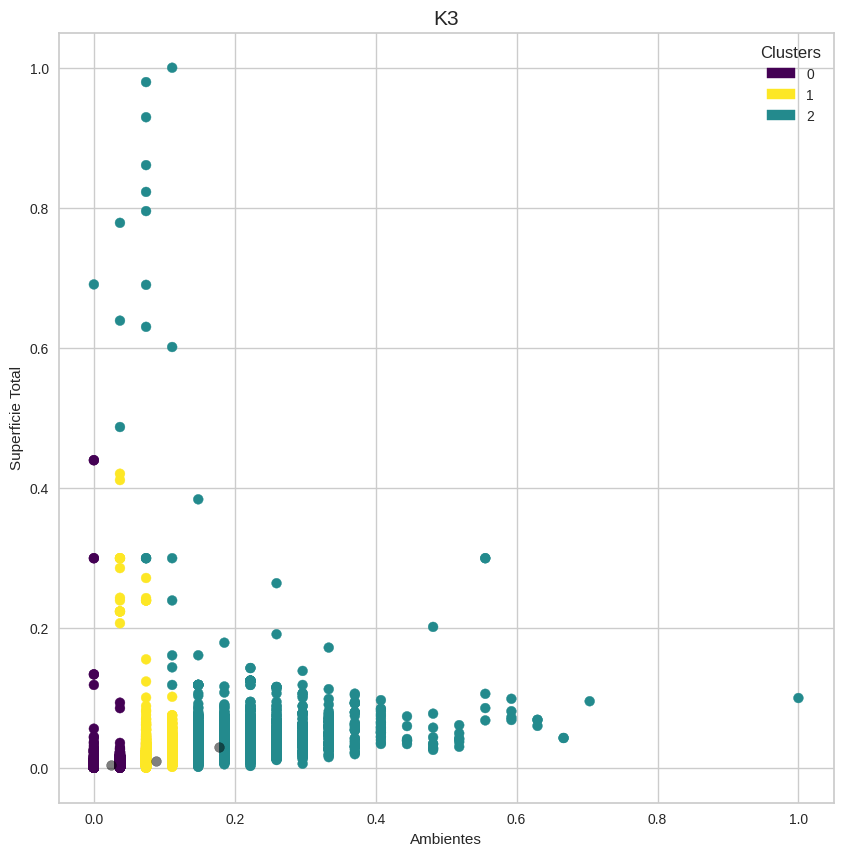

In [ ]:
grupos_kmeans_3 = pd.DataFrame(y_kmeans_3)
grupos_kmeans_3.rename(columns = {0:'grupo'}, inplace=True)

color_map = {0: '#440154FF', 1: '#FDE725FF', 2:'#238A8DFF'}
colores = grupos_kmeans_3['grupo'].map(color_map)

fx, ax = plt.subplots(figsize=(10,10))

plt.scatter(propiedades_atributos_escalados[:, 0], propiedades_atributos_escalados[:, 1], s = 50, c = colores)

legend_elements = [Patch(facecolor = '#440154FF', edgecolor = '#440154FF', label = 0),
                   Patch(facecolor = '#FDE725FF', edgecolor = '#FDE725FF', label = 1),
                   Patch(facecolor = '#238A8DFF', edgecolor = '#238A8DFF', label = 2)]
ax.legend(handles = legend_elements, title = 'Clusters', loc = 'upper right')

centers = kmeans_3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5, marker = '.')

plt.xlabel('Ambientes')
plt.ylabel('Superficie Total')
plt.title('K3', fontsize = 15)

plt.savefig('k3.png', bbox_inches = 'tight')
plt.show()

Si alguien quiere descargar el grafico localmente, ejecute las siguientes lineas en un bloque de codigo.
```
from google.colab import files
files.download('k3.png')
```

In [ ]:
grupos_kmeans_3.value_counts()

grupo
1        34512
0        32569
2         6930
Name: count, dtype: int64

Contrario al caso de la clusterización de ${k=2}$, aquí no podemos estimar en funcion de se forman que los tres grupos.

Lo unico que podemos inferir es que las propiedades que superan cierto umbral en la variable *ambientes* pertenecen al cluster <font color='21918C'>2</font>. Sin embargo, esto no aporta demasiada informacion ya que este cluster es el que menos cantidad de propiedades tiene.

## Visualizacion de grupos en mapa BSAS

Para terminar, observamos como se distribuyen ambos modelos en un mapa de CABA, y de esta forma comprobamos si algun cluster se concentra o no en alguna zona puntual.

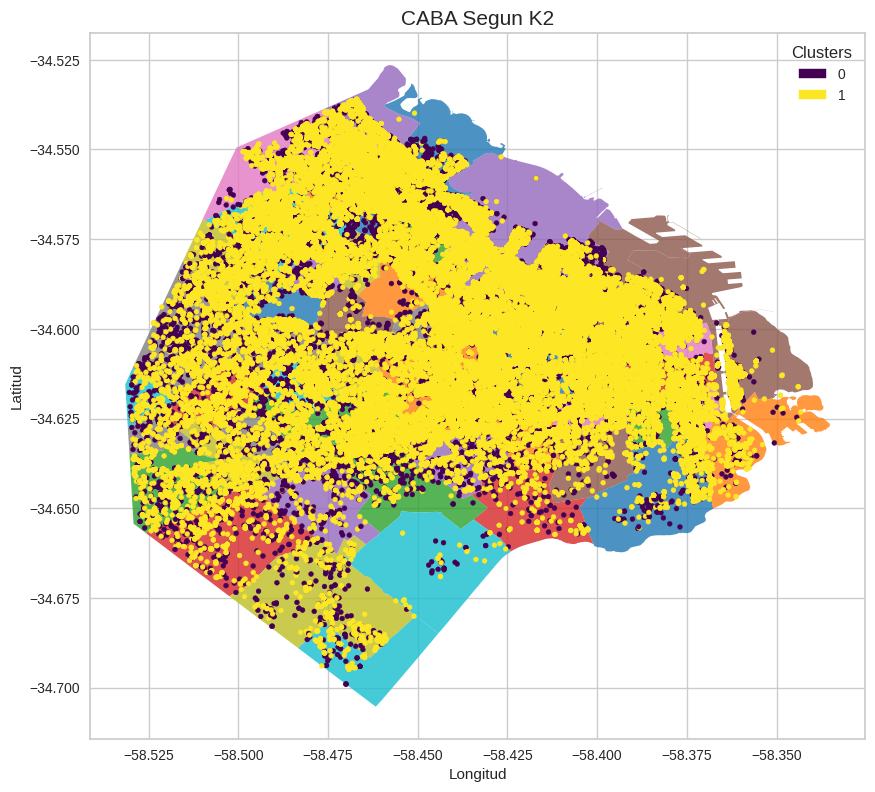

In [ ]:
color_map = {0: '#440154FF', 1: '#FDE725FF'}
colores = grupos_kmeans_2['grupo'].map(color_map)

points = propiedades[['longitud','latitud']]
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax = ax, c = colores, marker = '.', label = 'Clusters')

legend_elements = [Patch(facecolor = '#440154FF', edgecolor = '#440154FF', label = 0),
                   Patch(facecolor = '#FDE725FF', edgecolor = '#FDE725FF', label = 1)]
ax.legend(handles = legend_elements, title = 'Clusters', loc = 'upper right')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.title('CABA Segun K2', fontsize = 15)

plt.savefig('caba_k2.png', bbox_inches = 'tight')

plt.show()

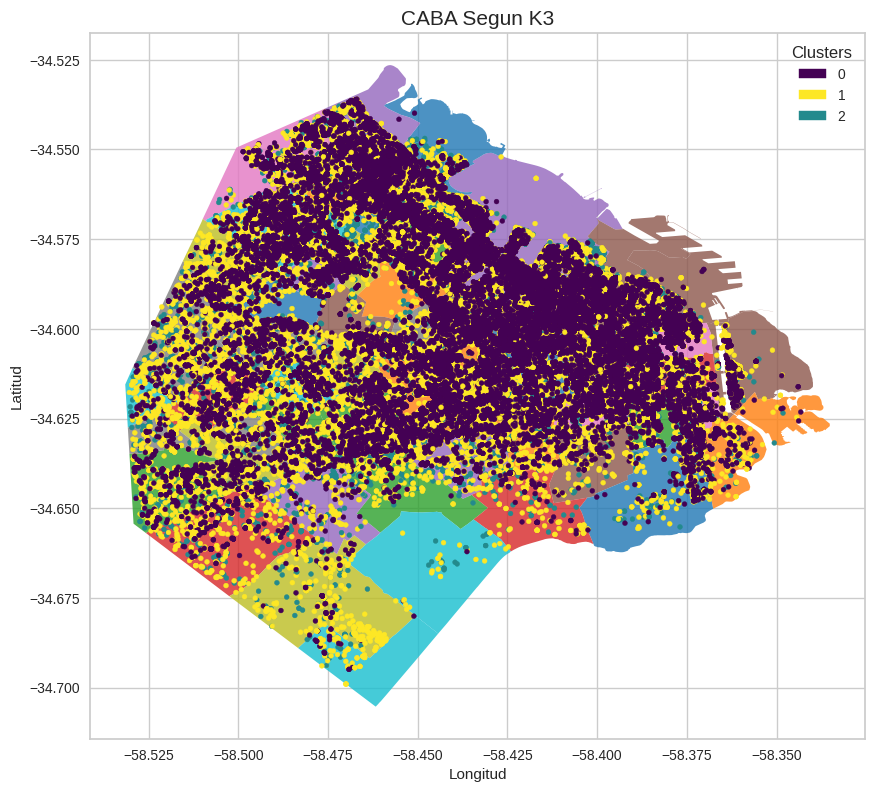

In [ ]:
color_map = {0: '#440154FF', 1: '#FDE725FF', 2:'#238A8DFF'}
colores = grupos_kmeans_3['grupo'].map(color_map)

points = propiedades[['longitud','latitud']]
points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.longitud, points.latitud))

fx, ax = plt.subplots(figsize = (10,10))
coordenadas_bsas.plot(ax = ax, column = 'BARRIO', alpha = 0.8)
points.plot(ax = ax, c = colores, marker = '.', label = 'Clusters')

legend_elements = [Patch(facecolor = '#440154FF', edgecolor = '#440154FF', label = 0),
                   Patch(facecolor = '#FDE725FF', edgecolor = '#FDE725FF', label = 1),
                   Patch(facecolor = '#238A8DFF', edgecolor = '#238A8DFF', label = 2)]
ax.legend(handles = legend_elements, title = 'Clusters', loc = 'upper right')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

plt.title('CABA Segun K3', fontsize = 15)

plt.savefig('caba_k3.png', bbox_inches = 'tight')

plt.show()

Si alguien quiere descargar el grafico localmente, ejecute las siguientes lineas en un bloque de codigo.
```
from google.colab import files
files.download('caba_k3.png')
```



Concluimos en base a los graficos que ni en K2 ni en K3 hay alguna agrupacion en el mapa de CABA.